# 03 · Pipeline Principal: Registro y Medición
**Objetivo:** emparejar 3 imágenes reales, estimar homografías (RANSAC), crear mosaico con *feather blending*, fijar escala con referencia conocida y medir elementos.

In [15]:
import os

# Ir al root del repo (sube un nivel desde /notebooks)
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import glob
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

from src.feature_detection import detect_and_describe
from src.matching import match_descriptors
from src.registration import estimate_homography, stitch_images_blend
from src.measurement import set_scale_by_two_points, measure_distance, interactive_pick_points
from src.utils import imread_color

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = True

DATA_DIR = "data/original"
from pathlib import Path
NOTEBOOK_NAME = "03_main_pipeline"
FIG_DIR = str(Path("results/figures") / NOTEBOOK_NAME)
MEAS_DIR = "results/measurements"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MEAS_DIR, exist_ok=True)

## 1) Carga de 3 imágenes

In [16]:
paths = sorted(glob.glob(os.path.join(DATA_DIR, '*')))
assert len(paths) >= 3, "Coloca al menos 3 imágenes en data/original"
I1, I0, I2 = [imread_color(p) for p in paths[:3]]
for i, p in enumerate(paths[:3]):
    print(f"[{i}] {os.path.basename(p)} -> {I0.shape if i==0 else (I1.shape if i==1 else I2.shape)}")

[0] IMG01.jpg -> (4032, 3024, 3)
[1] IMG02.jpg -> (4032, 3024, 3)
[2] IMG03.jpg -> (3024, 4032, 3)


## 2) Detección, matching, RANSAC y mosaico por detector
Para cada detector (SIFT, ORB, AKAZE) se muestran: keypoints, matching, matching (solo inliers) y, por último, el mosaico resultante.

Detector: SIFT


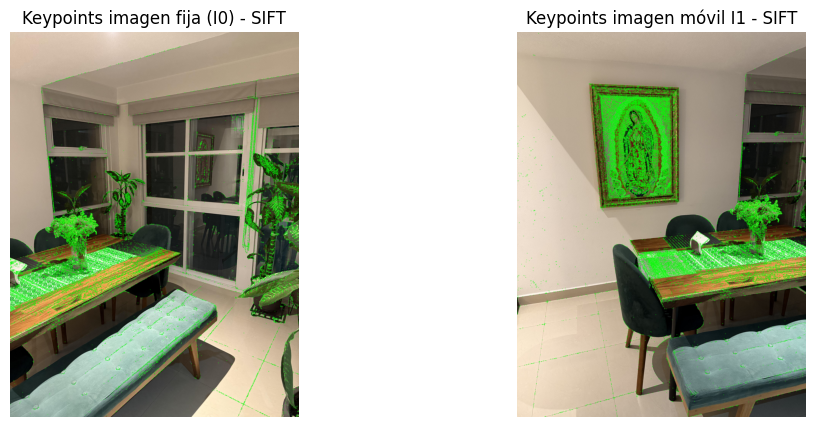

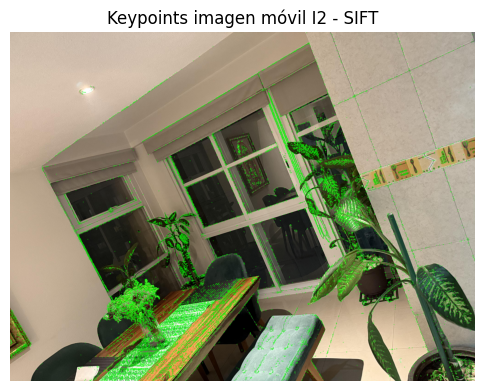

Guardados keypoints SIFT
Buenos matches I1->I0: 5999 | I2->I0: 6088
Guardados matches good SIFT


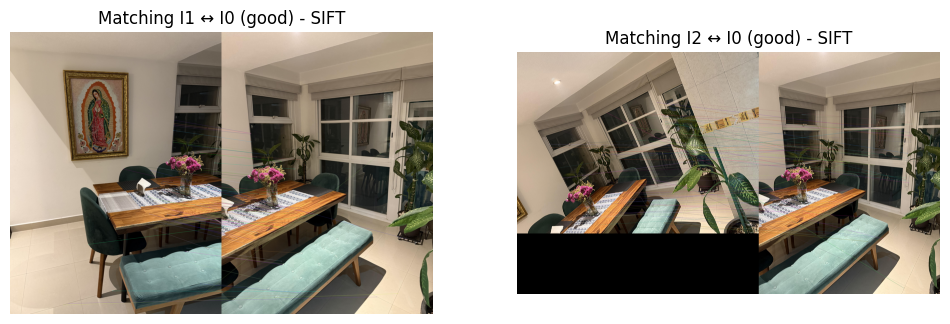

Inliers I1->I0: 3578 | Inliers I2->I0: 2573
Guardados inliers SIFT


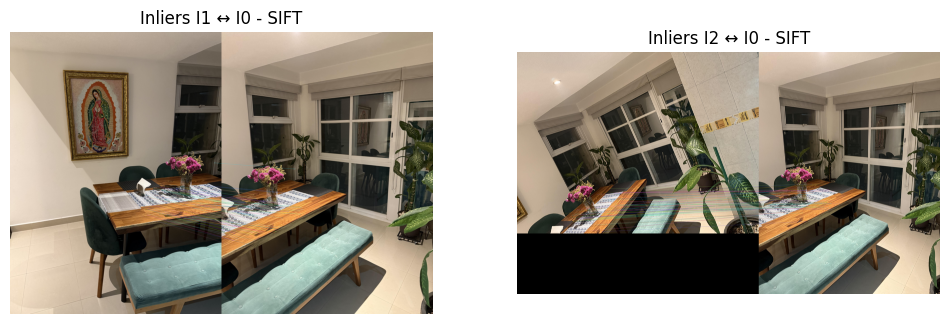

Guardado mosaico: results\figures\03_main_pipeline\mosaico_SIFT.jpg


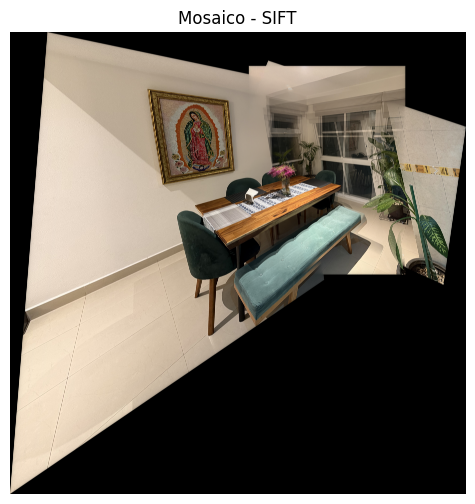

In [17]:
from src.utils import draw_matches

# Inicializar contenedores para mosaicos y puntajes (se llenarán en las celdas por detector)
mosaicos = {}
scores = {}

# --- Detector: SIFT ---
print("=" * 32)
print("Detector: SIFT")

# 1) Detect & describe
k0, d0 = detect_and_describe(I0, method="SIFT")
k1, d1 = detect_and_describe(I1, method="SIFT")
k2, d2 = detect_and_describe(I2, method="SIFT")

# Mostrar keypoints
img0_kp = I0.copy(); img0_kp = cv.drawKeypoints(I0, k0, img0_kp, color=(0, 255, 0))
img1_kp = I1.copy(); img1_kp = cv.drawKeypoints(I1, k1, img1_kp, color=(0, 255, 0))
img2_kp = I2.copy(); img2_kp = cv.drawKeypoints(I2, k2, img2_kp, color=(0, 255, 0))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(img0_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen fija (I0) - SIFT"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(img1_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen móvil I1 - SIFT"); plt.axis('off')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(cv.cvtColor(img2_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen móvil I2 - SIFT"); plt.axis('off')
plt.show()

# Guardar keypoints
cv.imwrite(os.path.join(FIG_DIR, "SIFT_keypoints_I0.jpg"), img0_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "SIFT_keypoints_I1.jpg"), img1_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "SIFT_keypoints_I2.jpg"), img2_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados keypoints SIFT")

# 2) Matching (good matches)
strategy = "FLANN"
m10 = match_descriptors(d1, d0, strategy=strategy, ratio=0.75)
m20 = match_descriptors(d2, d0, strategy=strategy, ratio=0.75)
print(f"Buenos matches I1->I0: {len(m10)} | I2->I0: {len(m20)}")

drawn10 = draw_matches(I1, k1, I0, k0, m10, max_draw=80)
drawn20 = draw_matches(I2, k2, I0, k0, m20, max_draw=80)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(drawn10, cv.COLOR_BGR2RGB)); plt.title("Matching I1 ↔ I0 (good) - SIFT"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(drawn20, cv.COLOR_BGR2RGB)); plt.title("Matching I2 ↔ I0 (good) - SIFT"); plt.axis('off')

# Guardar matches (good)
cv.imwrite(os.path.join(FIG_DIR, "SIFT_matching_I1_I0_good.jpg"), drawn10, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "SIFT_matching_I2_I0_good.jpg"), drawn20, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados matches good SIFT")
plt.show()

# 3) RANSAC e inliers
H10, in10 = estimate_homography(k1, k0, m10, ransac_thresh=3.0)
H20, in20 = estimate_homography(k2, k0, m20, ransac_thresh=3.0)
n_in10 = int(in10.sum()); n_in20 = int(in20.sum())
print(f"Inliers I1->I0: {n_in10} | Inliers I2->I0: {n_in20}")

inliers10 = [m for m, f in zip(m10, in10.ravel().tolist()) if f]
inliers20 = [m for m, f in zip(m20, in20.ravel().tolist()) if f]

drawn_in10 = draw_matches(I1, k1, I0, k0, inliers10, max_draw=80)
drawn_in20 = draw_matches(I2, k2, I0, k0, inliers20, max_draw=80)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(drawn_in10, cv.COLOR_BGR2RGB)); plt.title("Inliers I1 ↔ I0 - SIFT"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(drawn_in20, cv.COLOR_BGR2RGB)); plt.title("Inliers I2 ↔ I0 - SIFT"); plt.axis('off')

# Guardar inliers
cv.imwrite(os.path.join(FIG_DIR, "SIFT_inliers_I1_I0.jpg"), drawn_in10, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "SIFT_inliers_I2_I0.jpg"), drawn_in20, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados inliers SIFT")
plt.show()

# 4) Mosaico (stitch)
pano = stitch_images_blend([I0, I1, I2], [H10, H20], blend="feather")
mosaicos["SIFT"] = pano
scores["SIFT"] = n_in10 + n_in20
out_mosaic = os.path.join(FIG_DIR, "mosaico_SIFT.jpg")
cv.imwrite(out_mosaic, pano, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardado mosaico:", out_mosaic)

plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(pano, cv.COLOR_BGR2RGB))
plt.title("Mosaico - SIFT")
plt.axis('off')
plt.show()

Detector: ORB


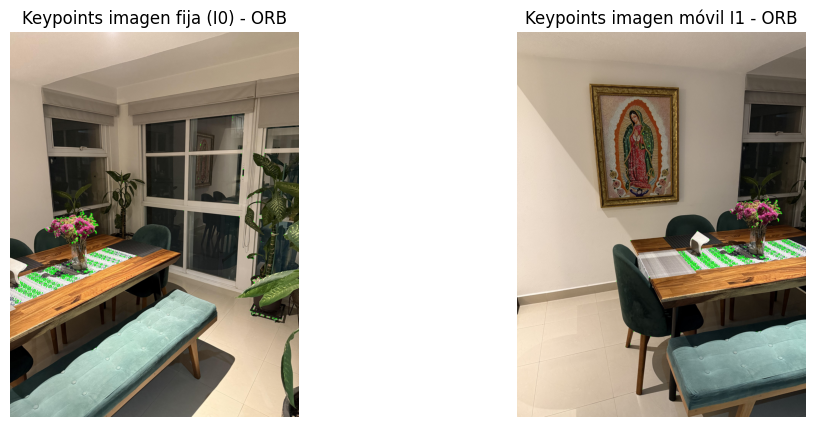

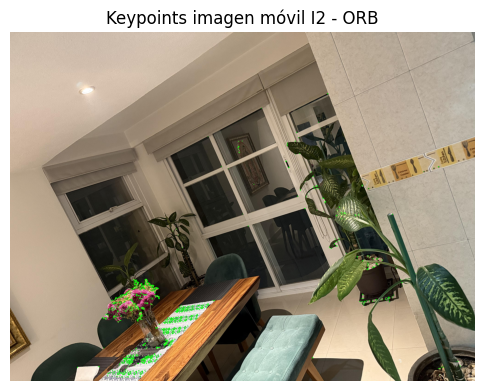

Guardados keypoints ORB
Buenos matches I1->I0: 1112 | I2->I0: 1091
Guardados matches good ORB


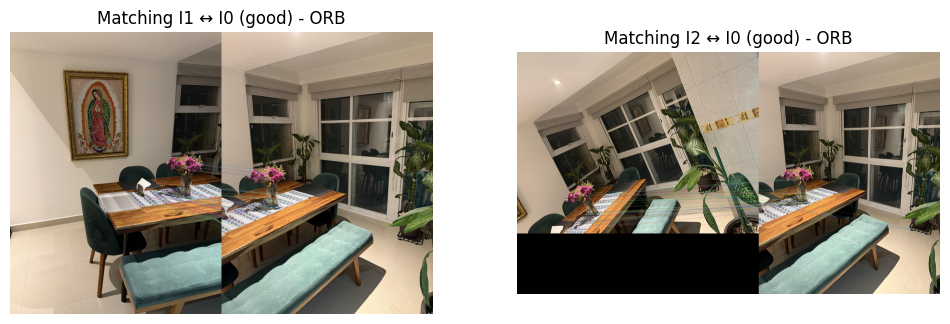

Inliers I1->I0: 801 | Inliers I2->I0: 665
Guardados inliers ORB


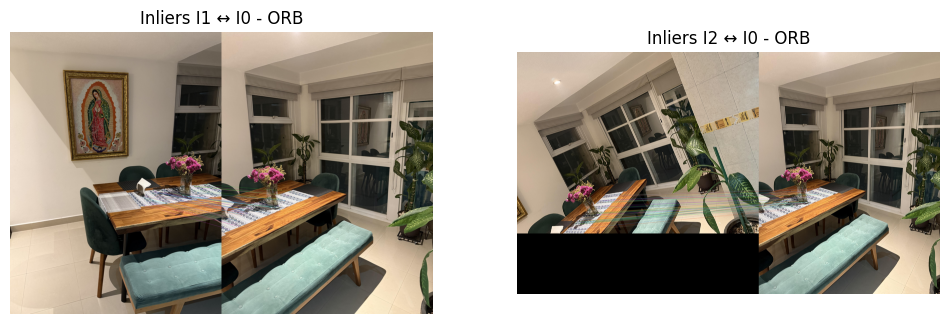

Guardado mosaico: results\figures\03_main_pipeline\mosaico_ORB.jpg


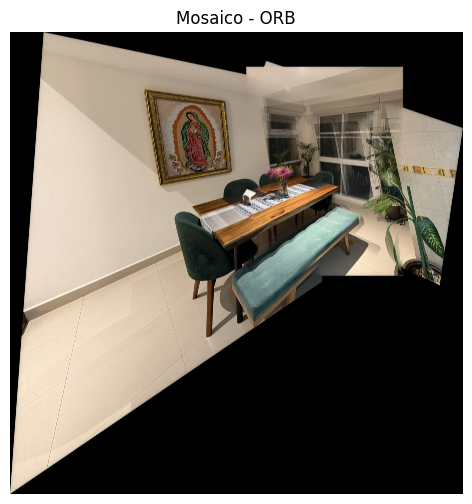

In [18]:
# --- Detector: ORB ---
print("=" * 32)
print("Detector: ORB")

# Asegurar contenedores
if 'mosaicos' not in globals():
    mosaicos = {}
if 'scores' not in globals():
    scores = {}

# 1) Detect & describe
k0, d0 = detect_and_describe(I0, method="ORB")
k1, d1 = detect_and_describe(I1, method="ORB")
k2, d2 = detect_and_describe(I2, method="ORB")

# Mostrar keypoints
img0_kp = I0.copy(); img0_kp = cv.drawKeypoints(I0, k0, img0_kp, color=(0, 255, 0))
img1_kp = I1.copy(); img1_kp = cv.drawKeypoints(I1, k1, img1_kp, color=(0, 255, 0))
img2_kp = I2.copy(); img2_kp = cv.drawKeypoints(I2, k2, img2_kp, color=(0, 255, 0))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(img0_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen fija (I0) - ORB"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(img1_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen móvil I1 - ORB"); plt.axis('off')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(cv.cvtColor(img2_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen móvil I2 - ORB"); plt.axis('off')
plt.show()

# Guardar keypoints
cv.imwrite(os.path.join(FIG_DIR, "ORB_keypoints_I0.jpg"), img0_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "ORB_keypoints_I1.jpg"), img1_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "ORB_keypoints_I2.jpg"), img2_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados keypoints ORB")

# 2) Matching (good matches)
strategy = "BF"
m10 = match_descriptors(d1, d0, strategy=strategy, ratio=0.75)
m20 = match_descriptors(d2, d0, strategy=strategy, ratio=0.75)
print(f"Buenos matches I1->I0: {len(m10)} | I2->I0: {len(m20)}")

drawn10 = draw_matches(I1, k1, I0, k0, m10, max_draw=80)
drawn20 = draw_matches(I2, k2, I0, k0, m20, max_draw=80)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(drawn10, cv.COLOR_BGR2RGB)); plt.title("Matching I1 ↔ I0 (good) - ORB"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(drawn20, cv.COLOR_BGR2RGB)); plt.title("Matching I2 ↔ I0 (good) - ORB"); plt.axis('off')

# Guardar matches (good)
cv.imwrite(os.path.join(FIG_DIR, "ORB_matching_I1_I0_good.jpg"), drawn10, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "ORB_matching_I2_I0_good.jpg"), drawn20, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados matches good ORB")
plt.show()

# 3) RANSAC e inliers
H10, in10 = estimate_homography(k1, k0, m10, ransac_thresh=3.0)
H20, in20 = estimate_homography(k2, k0, m20, ransac_thresh=3.0)
n_in10 = int(in10.sum()); n_in20 = int(in20.sum())
print(f"Inliers I1->I0: {n_in10} | Inliers I2->I0: {n_in20}")

inliers10 = [m for m, f in zip(m10, in10.ravel().tolist()) if f]
inliers20 = [m for m, f in zip(m20, in20.ravel().tolist()) if f]

drawn_in10 = draw_matches(I1, k1, I0, k0, inliers10, max_draw=80)
drawn_in20 = draw_matches(I2, k2, I0, k0, inliers20, max_draw=80)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(drawn_in10, cv.COLOR_BGR2RGB)); plt.title("Inliers I1 ↔ I0 - ORB"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(drawn_in20, cv.COLOR_BGR2RGB)); plt.title("Inliers I2 ↔ I0 - ORB"); plt.axis('off')

# Guardar inliers
cv.imwrite(os.path.join(FIG_DIR, "ORB_inliers_I1_I0.jpg"), drawn_in10, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "ORB_inliers_I2_I0.jpg"), drawn_in20, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados inliers ORB")
plt.show()

# 4) Mosaico (stitch)
pano = stitch_images_blend([I0, I1, I2], [H10, H20], blend="feather")
mosaicos["ORB"] = pano
scores["ORB"] = n_in10 + n_in20
out_mosaic = os.path.join(FIG_DIR, "mosaico_ORB.jpg")
cv.imwrite(out_mosaic, pano, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardado mosaico:", out_mosaic)

plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(pano, cv.COLOR_BGR2RGB))
plt.title("Mosaico - ORB")
plt.axis('off')
plt.show()


Detector: AKAZE


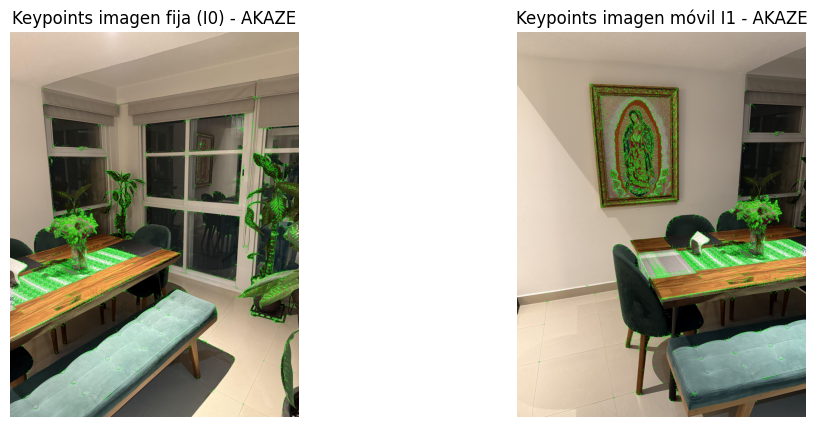

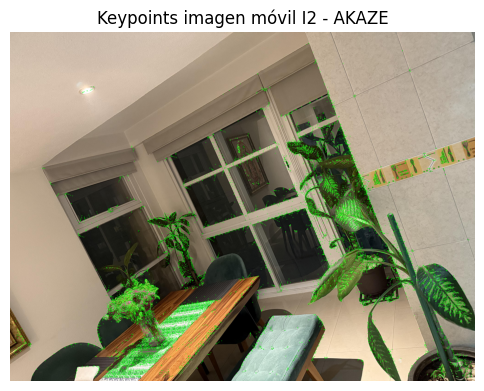

Guardados keypoints AKAZE
Buenos matches I1->I0: 3638 | I2->I0: 4868
Guardados matches good AKAZE


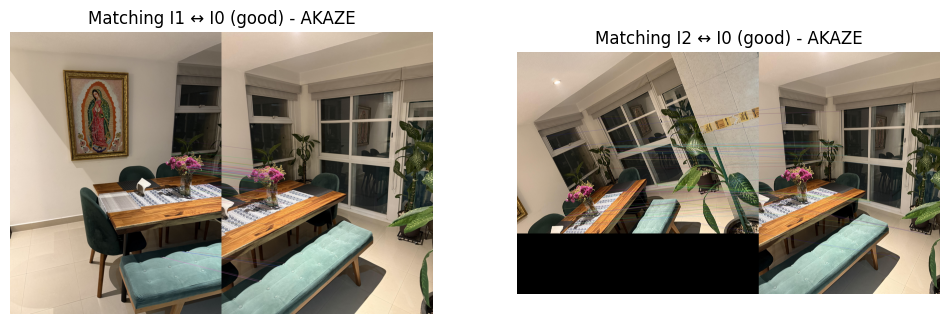

Inliers I1->I0: 1834 | Inliers I2->I0: 1921
Guardados inliers AKAZE


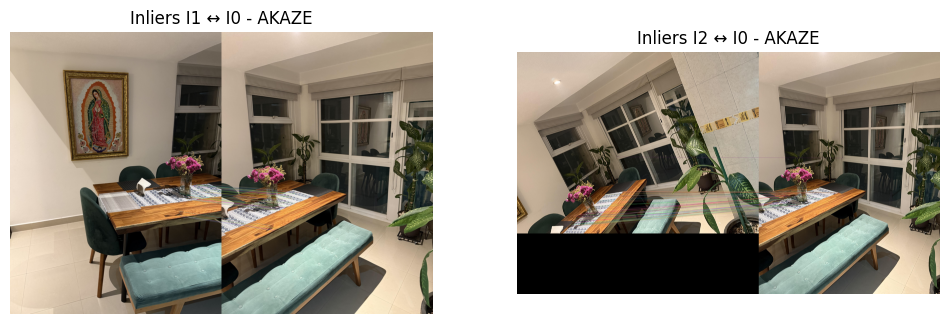

Guardado mosaico: results\figures\03_main_pipeline\mosaico_AKAZE.jpg


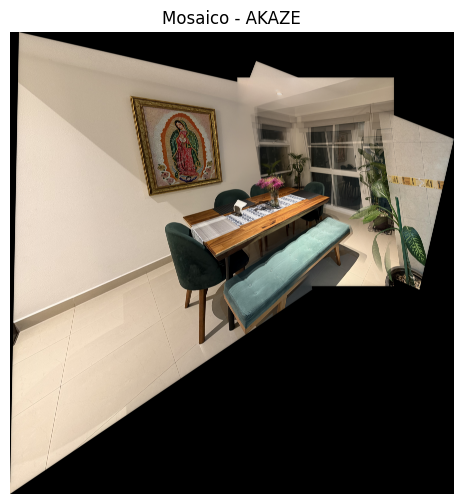

In [19]:
# --- Detector: AKAZE ---
print("=" * 32)
print("Detector: AKAZE")

# Asegurar contenedores
if 'mosaicos' not in globals():
    mosaicos = {}
if 'scores' not in globals():
    scores = {}

# 1) Detect & describe
k0, d0 = detect_and_describe(I0, method="AKAZE")
k1, d1 = detect_and_describe(I1, method="AKAZE")
k2, d2 = detect_and_describe(I2, method="AKAZE")

# Mostrar keypoints
img0_kp = I0.copy(); img0_kp = cv.drawKeypoints(I0, k0, img0_kp, color=(0, 255, 0))
img1_kp = I1.copy(); img1_kp = cv.drawKeypoints(I1, k1, img1_kp, color=(0, 255, 0))
img2_kp = I2.copy(); img2_kp = cv.drawKeypoints(I2, k2, img2_kp, color=(0, 255, 0))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(img0_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen fija (I0) - AKAZE"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(img1_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen móvil I1 - AKAZE"); plt.axis('off')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(cv.cvtColor(img2_kp, cv.COLOR_BGR2RGB)); plt.title("Keypoints imagen móvil I2 - AKAZE"); plt.axis('off')
plt.show()

# Guardar keypoints
cv.imwrite(os.path.join(FIG_DIR, "AKAZE_keypoints_I0.jpg"), img0_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "AKAZE_keypoints_I1.jpg"), img1_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "AKAZE_keypoints_I2.jpg"), img2_kp, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados keypoints AKAZE")

# 2) Matching (good matches)
strategy = "FLANN"
m10 = match_descriptors(d1, d0, strategy=strategy, ratio=0.75)
m20 = match_descriptors(d2, d0, strategy=strategy, ratio=0.75)
print(f"Buenos matches I1->I0: {len(m10)} | I2->I0: {len(m20)}")

drawn10 = draw_matches(I1, k1, I0, k0, m10, max_draw=80)
drawn20 = draw_matches(I2, k2, I0, k0, m20, max_draw=80)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(drawn10, cv.COLOR_BGR2RGB)); plt.title("Matching I1 ↔ I0 (good) - AKAZE"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(drawn20, cv.COLOR_BGR2RGB)); plt.title("Matching I2 ↔ I0 (good) - AKAZE"); plt.axis('off')

# Guardar matches (good)
cv.imwrite(os.path.join(FIG_DIR, "AKAZE_matching_I1_I0_good.jpg"), drawn10, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "AKAZE_matching_I2_I0_good.jpg"), drawn20, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados matches good AKAZE")
plt.show()

# 3) RANSAC e inliers
H10, in10 = estimate_homography(k1, k0, m10, ransac_thresh=3.0)
H20, in20 = estimate_homography(k2, k0, m20, ransac_thresh=3.0)
n_in10 = int(in10.sum()); n_in20 = int(in20.sum())
print(f"Inliers I1->I0: {n_in10} | Inliers I2->I0: {n_in20}")

inliers10 = [m for m, f in zip(m10, in10.ravel().tolist()) if f]
inliers20 = [m for m, f in zip(m20, in20.ravel().tolist()) if f]

drawn_in10 = draw_matches(I1, k1, I0, k0, inliers10, max_draw=80)
drawn_in20 = draw_matches(I2, k2, I0, k0, inliers20, max_draw=80)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv.cvtColor(drawn_in10, cv.COLOR_BGR2RGB)); plt.title("Inliers I1 ↔ I0 - AKAZE"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv.cvtColor(drawn_in20, cv.COLOR_BGR2RGB)); plt.title("Inliers I2 ↔ I0 - AKAZE"); plt.axis('off')

# Guardar inliers
cv.imwrite(os.path.join(FIG_DIR, "AKAZE_inliers_I1_I0.jpg"), drawn_in10, [cv.IMWRITE_JPEG_QUALITY, 90])
cv.imwrite(os.path.join(FIG_DIR, "AKAZE_inliers_I2_I0.jpg"), drawn_in20, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardados inliers AKAZE")
plt.show()

# 4) Mosaico (stitch)
pano = stitch_images_blend([I0, I1, I2], [H10, H20], blend="feather")
mosaicos["AKAZE"] = pano
scores["AKAZE"] = n_in10 + n_in20
out_mosaic = os.path.join(FIG_DIR, "mosaico_AKAZE.jpg")
cv.imwrite(out_mosaic, pano, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardado mosaico:", out_mosaic)

plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(pano, cv.COLOR_BGR2RGB))
plt.title("Mosaico - AKAZE")
plt.axis('off')
plt.show()


Usaremos 'SIFT' para medición. Inliers totales = 6151
Guardado mosaico seleccionado: results\figures\03_main_pipeline\mosaico_selected_SIFT.jpg


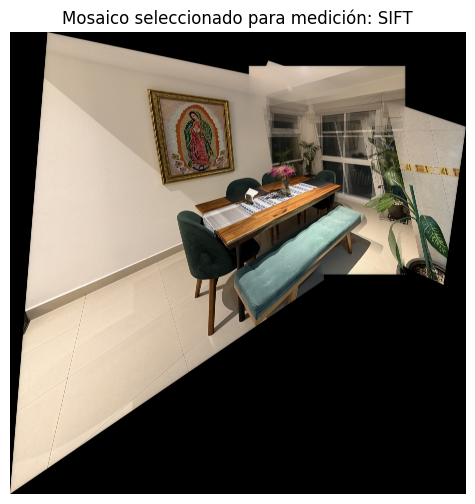

In [20]:
# --- Selección de mejor mosaico ---
if len(scores):
    best_method = max(scores.keys(), key=lambda k: scores[k])
else:
    best_method = "SIFT"

mosaico = mosaicos[best_method]
print(f"Usaremos '{best_method}' para medición. Inliers totales = {scores.get(best_method, 0)}")

# Guardar mosaico seleccionado
out_best = os.path.join(FIG_DIR, f"mosaico_selected_{best_method}.jpg")
cv.imwrite(out_best, mosaico, [cv.IMWRITE_JPEG_QUALITY, 90])
print("Guardado mosaico seleccionado:", out_best)

plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(mosaico, cv.COLOR_BGR2RGB))
plt.title(f"Mosaico seleccionado para medición: {best_method}")
plt.axis('off')
plt.show()


## 5) Fijar escala y medir
Para la escala, selecciona **dos puntos** sobre una referencia conocida (por ejemplo, altura del cuadro = **117 cm**).
Luego, valida midiendo el **ancho de la mesa** (valor conocido **161.1 cm**).
Después, mide **al menos 3 elementos adicionales** y guarda resultados.

In [21]:
# --- Escala con referencia conocida ---
print("Selecciona 2 puntos de la referencia (ej. altura del cuadro = 117 cm)")
ref_pts = interactive_pick_points(mosaico, npoints=2)
scale = set_scale_by_two_points(ref_pts[0], ref_pts[1], real_distance_cm=117.0)

# --- Validación con mesa ---
print("Selecciona 2 puntos que representen el ancho de la mesa (valor real: 161.1 cm)")
mesa_pts = interactive_pick_points(mosaico, npoints=2)
mesa_cm = measure_distance(mesa_pts[0], mesa_pts[1], scale)
mesa_err = mesa_cm - 161.1
print(f"Ancho mesa estimado: {mesa_cm:.2f} cm | Error: {mesa_err:.2f} cm")

# --- Medir ≥3 elementos adicionales ---
mediciones = []
def medir_elemento(nombre: str):
    print(f"Selecciona 2 puntos para '{nombre}'")
    pts = interactive_pick_points(mosaico, npoints=2)
    d = measure_distance(pts[0], pts[1], scale)
    mediciones.append({"elemento": nombre, "dist_cm": d})
    print(f"{nombre}: {d:.2f} cm")

items = ["Elemento_1", "Elemento_2", "Elemento_3"]
for it in items:
    medir_elemento(it)

# Guardar a CSV
now = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(MEAS_DIR, f"mediciones_{now}.csv")
df = pd.DataFrame(mediciones + [
    {"elemento": "VALIDACION_MESA", "dist_cm": mesa_cm, "error_vs_161_1": mesa_err}
])
df.to_csv(csv_path, index=False)
print("Guardado:", csv_path)

Selecciona 2 puntos de la referencia (ej. altura del cuadro = 117 cm)
Selecciona 2 puntos que representen el ancho de la mesa (valor real: 161.1 cm)
Ancho mesa estimado: 155.99 cm | Error: -5.11 cm
Selecciona 2 puntos para 'Elemento_1'
Elemento_1: 167.77 cm
Selecciona 2 puntos para 'Elemento_2'
Elemento_2: 86.40 cm
Selecciona 2 puntos para 'Elemento_3'
Elemento_3: 132.46 cm
Guardado: results/measurements\mediciones_20251106_195328.csv
